In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('kitty_level_4', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 0.01

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False, width_scale = [0.4, 1])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [57]:
# set_surface_view_options(curved_linkage_view, surface_transparent = True)

In [69]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [66]:
# double_view = get_double_side_view(curved_linkage)

In [67]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [68]:
curved_linkage_view.update(scalarField=colors)

In [6]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/kitty_level_4/kitty_level_4_dof.npy'))

Min Width  0.013309415701373561
num seg per rod 88


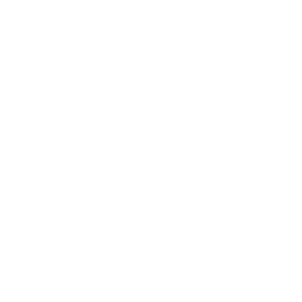

In [8]:
get_all_curve_pattern(curved_linkage, min(io.RIBBON_CS), io.SUBDIVISION_RESOLUTION, io.RIBBON_NAME, 'svg', target_ribbon_width = 2, flip_angles = True, select_ribbon_index = [5])

In [59]:
curved_linkage.attraction_weight = 1e-7

In [60]:
# curved_linkage.energy(elastic_rods.SurfaceAttractionEnergyType.Elastic)

In [61]:
# curved_linkage.energy(elastic_rods.SurfaceAttractionEnergyType.Attraction)

In [62]:
# iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [63]:
# curved_linkage.scaleJointWeights(0.1, 100, [214, 255, 39])

In [64]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [45]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	1.04978e-05	6.25954e-07	6.25954e-07	0	0


In [43]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view)

KeyboardInterrupt: 

In [21]:
# optimizer.scaleJointWeights(0.6, 100, [214, 255, 39])

In [22]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -1, 2)

stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.1


In [23]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

0.013258287975964018


In [24]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [25]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [26]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

Min Width  0.013309415701373561
num seg per rod 40
num seg per rod 40
num seg per rod 264
num seg per rod 40
num seg per rod 40
num seg per rod 88
num seg per rod 88
num seg per rod 40
num seg per rod 40
num seg per rod 94
num seg per rod 40
num seg per rod 84
num seg per rod 94
num seg per rod 40


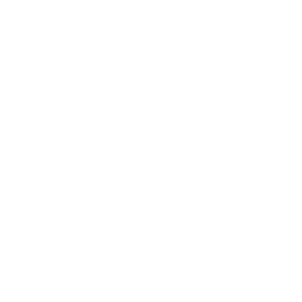

In [47]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 2, flip_angles = False)
os.chdir(save_path)

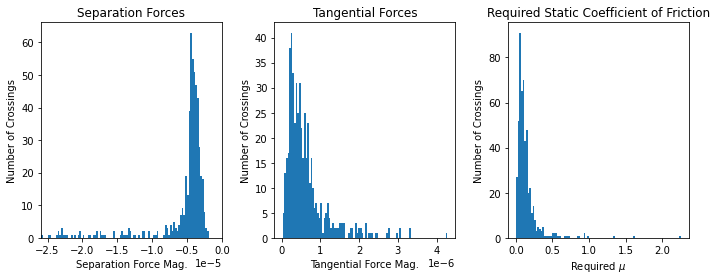

In [28]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [29]:
double_view = get_double_side_view(curved_linkage, flip = True)
double_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [30]:
double_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [ ]:
# optimizer.scaleJointWeights(0.1, 1000, [396, 412, 497])
# contact_optimization(optimizer, curved_linkage_view, -1, contact_weight = 1e4)

In [ ]:
# second_structure_view = get_structure_analysis_view(curved_linkage)
# second_structure_view.show()